In [1]:
%matplotlib inline
import tensorflow as tf
from d2l import tensorflow as d2l

# 4.1 感知机

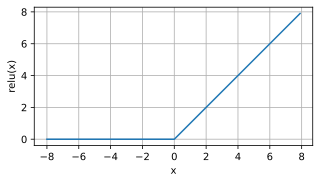

In [3]:
# ReLU 激活函数
x = tf.Variable(tf.range(-8., 8. , 0.1),dtype=tf.float32)
y = tf.nn.relu(x)
d2l.plot(x.numpy(), y.numpy(), 'x', 'relu(x)', figsize=(5,2.5))

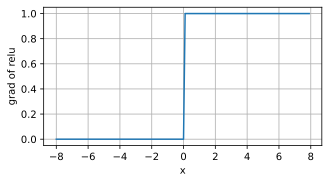

In [7]:
# ReLU 激活函数梯度
with tf.GradientTape() as t:
    y = tf.nn.relu(x)
d2l.plot(x.numpy(), t.gradient(y, x).numpy(), 'x', 'grad of relu', figsize=(5,2.5))

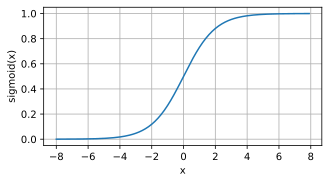

In [8]:
# Sigmoid 函数
y = tf.nn.sigmoid(x)
d2l.plot(x.numpy(), y.numpy(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

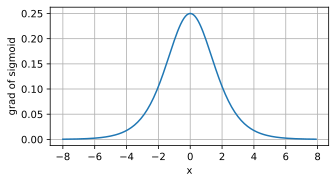

In [14]:
# Sigmoid 梯度
with tf.GradientTape() as t:
    y = tf.nn.sigmoid(x)
d2l.plot(x.numpy(), t.gradient(y, x).numpy(), 'x', 'grad of sigmoid', figsize=(5, 2.5))

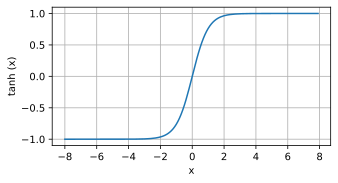

In [16]:
# tanh 函数
y = tf.nn.tanh(x)
d2l.plot(x.numpy(), y.numpy(), 'x', 'tanh (x)', figsize=(5,2.5))

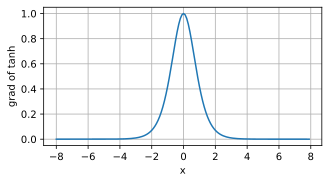

In [19]:
# tanh 梯度
with tf.GradientTape() as t:
    y = tf.nn.tanh(x)
d2l.plot(x.numpy(), t.gradient(y, x).numpy(), 'x', 'grad of tanh', figsize=(5, 2.5))

# 4.2 多层感知机从零开始实现

In [20]:
import tensorflow as tf
from d2l import tensorflow as d2l

In [21]:
batch_size = 32
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [22]:
# 初始化模型参数
num_inputs, num_outputs, num_hiddens = 784, 10, 256
w1 = tf.Variable(tf.random.normal(shape=(num_inputs, num_hiddens), mean=0, stddev=0.01))
b1 = tf.Variable(tf.zeros(num_hiddens))
w2 = tf.Variable(tf.random.normal(shape=(num_hiddens, num_outputs), mean=0, stddev=0.01))
b2 = tf.Variable(tf.zeros(num_outputs))
params = [w1, b1, w2, b2]

In [23]:
# 激活函数
def relu(x):
    return tf.nn.relu(x)

In [24]:
# 模型
def net(x):
    x = tf.reshape(x, (-1, num_inputs))
    x = relu(tf.matmul(x,w1) + b1)
    return tf.matmul(x, w2) + b2


In [25]:
# 损失函数
def loss(y_hat, y):
    return tf.losses.sparse_categorical_crossentropy(y, y_hat, from_logits=True)

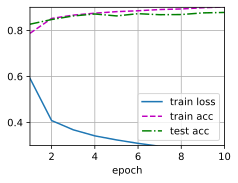

In [26]:
# 训练
num_epoch = 10
lr = 0.1
updater = d2l.Updater([w1, w2, b1, b2], lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epoch, updater)

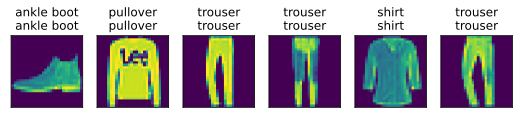

In [27]:
# 验证
d2l.predict_ch3(net, test_iter)

# 4.3 感知机的简洁实现

In [29]:
net = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10)
])

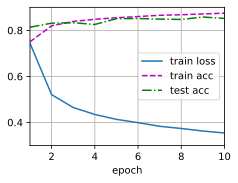

In [33]:
batch_size, lr, num_epochs = 256, 0.1, 10
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
trainer = tf.keras.optimizers.SGD(learning_rate=lr)

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

# 4.5 权重衰减

In [34]:
%matplotlib inline
import tensorflow as tf
from d2l import tensorflow as d2l

In [35]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = tf.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)

test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size)

In [36]:
# 从零开始实现

In [37]:
# 初始化模型参数
def init_params():
    w = tf.Variable(tf.random.normal(mean=1, shape=(num_inputs, 1)))
    b = tf.Variable(tf.zeros(shape=1,))
    return [w, b]

In [38]:
# 定义 L2 范数惩罚
def l2_penalty(w):
    return tf.reduce_sum(tf.pow(w, 2)) / 2

In [39]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with tf.GradientTape() as tape:
                # 增加了L2范数惩罚项，
                # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
                l = loss(net(X), y) + lambd * l2_penalty(w)
            grads = tape.gradient(l, [w, b])
            d2l.sgd([w, b], grads, lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', tf.norm(w).numpy())

w的L2范数是： 17.457544


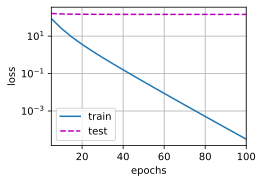

In [40]:
train(lambd=0)

w的L2范数是： 0.47386855


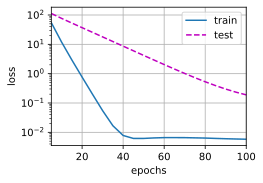

In [41]:
# 使用权重衰减
train(lambd=3)

# 4.6 暂退法（dropout）

In [1]:
# 从零开始实现
import tensorflow as tf
from d2l import tensorflow as d2l

In [2]:
def dropout_layer(x, dropout):
    assert 0 <= dropout <= 1
    if dropout == 0:
        return x
    if dropout == 1:
        return tf.zeros_like(x)

    mask = tf.random.uniform(shape=tf.shape(x), minval=0, maxval=1) < 1 - dropout
    return tf.cast(mask, dtype=tf.float32) * x / (1.0 - dropout)

In [4]:
x = tf.reshape(tf.range(16, dtype=tf.float32), (2,8))
print(x)
print(dropout_layer(x, 0))
print(dropout_layer(x, 1))
print(dropout_layer(x, 0.5))


tf.Tensor(
[[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14. 15.]], shape=(2, 8), dtype=float32)
tf.Tensor(
[[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14. 15.]], shape=(2, 8), dtype=float32)
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]], shape=(2, 8), dtype=float32)
tf.Tensor(
[[ 0.  2.  0.  6.  0. 10.  0.  0.]
 [16. 18. 20.  0.  0.  0.  0. 30.]], shape=(2, 8), dtype=float32)


In [17]:
# 定义模型参数
num_outputs, num_hiddens1, num_hiddens2 = 10, 256, 256
dropout1, dropout2 = 0.2, 0.5

class Net(tf.keras.Model):
    def __init__(self, num_outputs, num_hiddens1, num_hidddens2) -> None:
        super().__init__()
        self.input_layer = tf.keras.layers.Flatten()
        self.hidden1 = tf.keras.layers.Dense(num_hiddens1, activation='relu')
        self.hidden2 = tf.keras.layers.Dense(num_hidddens2, activation='relu')
        self.output_layer = tf.keras.layers.Dense(num_outputs)
    def call(self, inputs, training=None):
        x = self.input_layer(inputs)
        x = self.hidden1(x)
        if training:
            x = dropout_layer(x, dropout1)
        x = self.hidden2(x)
        if training:
            x = dropout_layer(x, dropout2)
        x = self.output_layer(x)
        return x


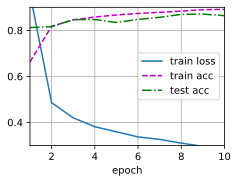

In [18]:
# 训练  这里给出的 dropout 实际上并没有起作用
net = Net(num_outputs=num_outputs, num_hiddens1=num_hiddens1, num_hidddens2=num_hiddens2)
num_epoch, lr, batch_size = 10, 0.5, 256
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = tf.keras.optimizers.SGD(learning_rate=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epoch, trainer)

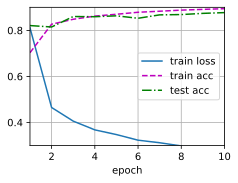

In [23]:
# 定义模型参数 dropout 想起作用，去改源码，训练和预测的时候分别传 True ，False 就好
num_outputs, num_hiddens1, num_hiddens2 = 10, 256, 256
dropout1, dropout2 = 0.2, 0.5

class Net(tf.keras.Model):
    def __init__(self, num_outputs, num_hiddens1, num_hidddens2) -> None:
        super().__init__()
        self.input_layer = tf.keras.layers.Flatten()
        self.hidden1 = tf.keras.layers.Dense(num_hiddens1, activation='relu')
        self.hidden2 = tf.keras.layers.Dense(num_hidddens2, activation='relu')
        self.output_layer = tf.keras.layers.Dense(num_outputs)
    def call(self, inputs, training):
        x = self.input_layer(inputs)
        x = self.hidden1(x)
        if training:
            x = dropout_layer(x, dropout1)
        x = self.hidden2(x)
        if training:
            x = dropout_layer(x, dropout2)
        x = self.output_layer(x)
        return x
net = Net(num_outputs=num_outputs, num_hiddens1=num_hiddens1, num_hidddens2=num_hiddens2)


# 训练
num_epoch, lr, batch_size = 10, 0.5, 256
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = tf.keras.optimizers.SGD(learning_rate=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epoch, trainer)

In [2]:
import tensorflow as tf
M = tf.random.normal((4, 4))
print('一个矩阵 \n', M)
for i in range(100):
    M = tf.matmul(M, tf.random.normal((4, 4)))

print('乘以100个矩阵后\n', M.numpy())

一个矩阵 
 tf.Tensor(
[[ 1.6132020e+00  6.4271338e-02 -8.7910664e-01  5.1309995e-04]
 [-7.2266442e-01 -1.6246680e+00  5.0288457e-01  2.6099315e-01]
 [-1.4806537e-01  8.3590262e-02  1.6479816e+00 -1.7163312e+00]
 [-7.7980340e-01  1.1352570e+00 -1.0988300e+00  7.7306116e-01]], shape=(4, 4), dtype=float32)
乘以100个矩阵后
 [[ 5.3500873e+24  2.1004915e+25  3.8264975e+23 -3.0644953e+24]
 [-2.2594310e+25 -8.8707275e+25 -1.6159936e+24  1.2941878e+25]
 [ 6.5974808e+25  2.5902298e+26  4.7186633e+24 -3.7789951e+25]
 [-3.2983994e+25 -1.2949808e+26 -2.3590941e+24  1.8893008e+25]]
